In [91]:
import ReactorSpectra
import histlite as hl
import numpy as np
import pandas as pd
import Detector
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.weight"] = 'light'
plt.rcParams["axes.labelweight"] = 'light'
plt.rcParams["font.family"] = ['Times New Roman']

# Introduction

This notebook contains our best estimate of the backgrounds in a search for 2nu- and 0nuB+EC decay. For this signal, one expects a unique event structure: a fast positron will scatter and excite/ionize the xenon in a primary track, and will then annihilate, producing two back-to-back gamma rays, each with 511 keV. The idea here is that a liquid xenon TPC will have the spatial position resolution to identify these events by their topology and reduce background to essentially zero.

There are a few sources of backgrounds that we consider here:

1. **Antineutrino charged-current scattering** - ~MeV-scale antineutrinos, either from geological sources or from reactors, can undergo charged-current scattering on the xenon nucleus. This process produces a positron, so if it has enough energy it will exactly mimic the signal of interest.

2. **Neutrino charged-currrent scattering** - ~MeV-scale neutrinos from the sun can also undergo charged-current scattering, which produces backgrounds of two different types:

    1. **Prompt neutrino capture into excited states** - The prompt signal from charged-current scattering is a fast electron, which should not meet our event selection criteria. However, if the resulting Cs nucleus is left in an excited state, the decay gammas may mimic the annihilation gammas, producing background events in our search.
    
    2. **Delayed emission of positrons by proton-rich Cs daughters** - Charged-current scattering on the lower-mass Xe isotopes produces Cs isotopes which decay via B+ emission. This exactly mimics our signal of interest.
    
    3. **Delayed beta decays into excited states** - Charged-current scattering on the higher-mass Xe isotopes can produce Cs isotopes that B-decay into excited states. The particular case here is Xe-136, since it has a low enough threshold to interact with Be7 and CNO neutrinos (which have much higher fluxes than B8 neutrinos)
    
3. **External gamma rays** - external gammas from natural radioactivity in the detector materials may mimic our signal topology by compton-scattering to produce multiple energy deposits. The pile-up of these gammas may have enough energy to reach the 2.8 MeV Q-value of the 0nuB+EC decay of Xe124 

5. **Neutron activation via (n,g), (n,p), or (n,a) reactions** - fast neutrons may reach the detector from muon spallation or from (a,n) reactions in the surrounding materials. Any induced radioactivity in the Xe may create backgrounds if it is a B+-emitter, or decays via B-decay to excited states. 

4. **222Rn decay inside the liquid xenon volume** - events from the Rn-222 decay chain may produce backgrounds for us.

We quantify and address each of these background sources below.

# Antineutrino charged-current scattering

First, we load in the energy-dependent cross sections, which were published in PhysRevC **99** 014320. The energy-dependent data was obtained directly from Pekka Pirinen.

In [46]:
cs_xe131 = pd.read_csv('pirinen_cross_sections/131Xe_I_antineutrino.dat',delimiter='\t',skiprows=2,index_col=False)
cs_xe129 = pd.read_csv('pirinen_cross_sections/129Xe_I_antineutrino.dat',delimiter='\t',skiprows=2,index_col=False)
cs_xe129.head()
cs_xe131.head()

,E,CS
0,1.0,0.0
1,1.2,0.0
2,1.4,0.0
3,1.6,0.0
4,1.8,0.0


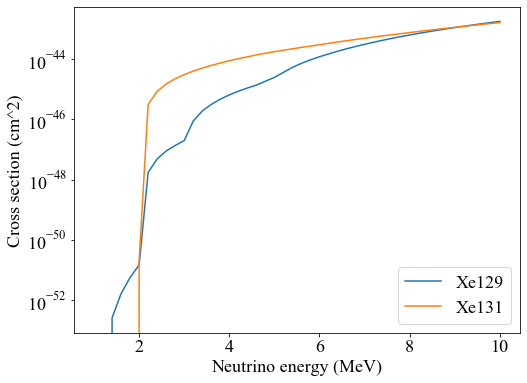

In [47]:
plt.plot(cs_xe129['E'],cs_xe129['CS'],label='Xe129')
plt.plot(cs_xe131['E'],cs_xe131['CS '],label='Xe131')

plt.ylabel('Cross section (cm^2)')
plt.xlabel('Neutrino energy (MeV)')
plt.legend(loc='lower right')

plt.yscale('log')

## Reactor antineutrinos

Let's first look at reactors as a source of backgrounds. We can download the a table of reactors all over the world which contains their locations and their thermal power. This allows us to calculate the flux at any point on the globe. For this study, we focus on the underground labs: Homestake, LNGS, and SNOLAB. I ignore oscillations for now - note that this is a conservative assumption, since only electron antinuetrinos will interact at energies this low. 


The data was obtained from https://www.ultralytics.com/agm2015

In [48]:
db_reactors = pd.read_csv('Reactor_neutrinos/Copy of Ultralytics Worldwide Reactor Database - Sheet1.csv')
print(db_reactors.head())
op_mask = db_reactors['Status'] == 'Operational'

     Country    Sitename                               Location  \
0        NaN         NaN                                    NaN   
1    ARMENIA  ARMENIAN-1                                Armavir   
2    ARMENIA  ARMENIAN-2                                Armavir   
3  ARGENTINA    ATUCHA-1  Zárate Partido, Buenos Aires Province   
4  ARGENTINA     EMBALSE        Calamuchita Department, Cordoba   

               Status  Gross (MWe)  Capacity (MWt)  Mean LF (%)  2015 LF (%)  \
0                 NaN          NaN             NaN          NaN          NaN   
1  Permanent Shutdown        408.0          1375.0          0.0          0.0   
2         Operational        408.0          1375.0         65.2         78.3   
3         Operational        357.0          1179.0         71.5         88.4   
4         Operational        648.0          2015.0         78.7         12.2   

   lat (-90 to 90)  lng (-180 to 180)  alt (m)  
0              NaN                NaN      NaN  
1        40.180844

In [49]:
# Coordinates of LNGS
lngs_lat = 42.454 # degrees north
lngs_lon = 13.576 # degrees east

# Coordinates of Homestake
home_lat = 44. + 21./60. # degrees north
home_lon = -(103. + 45./60.) # degrees west

sno_lat = 46.4719 # degrees north
sno_lon = -81.1868 # degrees west

# Radius of the earth
R = 6371.0 # km

In [50]:
# Write function to accept two locations in degrees on a sphere of radius R, then 
# calculate their true 3D distance from each other. We take the convention given 
# by the reactors sheet: latitude is measured from -90 to 90, and longitude is
# measured from -180 to 180
def distance_calc( R, lat1, lon1, lat2, lon2 ):
    if lat1 < 0.:
        lat1 = -1.*lat1 + 90.
    else:
        lat1 = 90. - lat1
    if lat2 < 0.:
        lat2 = -1.*lat2 + 90.
    else:
        lat2 = 90. - lat2
    if lon1 < 0.:
        lon1 = (-1.*lon1) + 180.
    if lon2 < 0.:
        lon2 = (-1.*lon2) + 180.
        
    x1 = R * np.sin(lat1*np.pi/180.) * np.cos(lon1*np.pi/180.)
    y1 = R * np.sin(lat1*np.pi/180.) * np.sin(lon1*np.pi/180.)
    z1 = R * np.cos(lat1*np.pi/180.)
    
    x2 = R * np.sin(lat2*np.pi/180.) * np.cos(lon2*np.pi/180.)
    y2 = R * np.sin(lat2*np.pi/180.) * np.sin(lon2*np.pi/180.)
    z2 = R * np.cos(lat2*np.pi/180.)
    
    #print('X1: {} Y1: {} Z1: {}'.format(x1,y1,z1))
    #print('X2: {} Y2: {} Z2: {}'.format(x2,y2,z2))
    #print('Dist: {}'.format(np.sqrt( (x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2 )))
    
    return np.sqrt( (x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2 )

In [51]:
# Add a column to the dataframe giving the distance of each reactor to each lab.

db_reactors['Dist to LNGS'] = np.zeros(len(db_reactors['lat (-90 to 90)']))

for index,row in db_reactors.iterrows():
    db_reactors['Dist to LNGS'].loc[index] = distance_calc(R,lngs_lat,lngs_lon,row['lat (-90 to 90)'],row['lng (-180 to 180)'])

db_reactors.head()

,Country,Sitename,Location,Status,Gross (MWe),Capacity (MWt),Mean LF (%),2015 LF (%),lat (-90 to 90),lng (-180 to 180),alt (m),Dist to LNGS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARMENIA,ARMENIAN-1,Armavir,Permanent Shutdown,408.0,1375.0,0.0,0.0,40.180844,44.148908,925.3,2534.847784
2,ARMENIA,ARMENIAN-2,Armavir,Operational,408.0,1375.0,65.2,78.3,40.180844,44.148908,925.3,2534.847784
3,ARGENTINA,ATUCHA-1,"Zárate Partido, Buenos Aires Province",Operational,357.0,1179.0,71.5,88.4,-33.963330,-59.186390,27.7,12105.474735
4,ARGENTINA,EMBALSE,"Calamuchita Department, Cordoba",Operational,648.0,2015.0,78.7,12.2,-32.232000,-64.443000,633.5,11932.338786


In [52]:
db_reactors['Dist to Homestake'] = np.zeros(len(db_reactors['lat (-90 to 90)']))

for index,row in db_reactors.iterrows():
    db_reactors['Dist to Homestake'].loc[index] = distance_calc(R,home_lat,home_lon,row['lat (-90 to 90)'],row['lng (-180 to 180)'])

db_reactors.head()

,Country,Sitename,Location,Status,Gross (MWe),Capacity (MWt),Mean LF (%),2015 LF (%),lat (-90 to 90),lng (-180 to 180),alt (m),Dist to LNGS,Dist to Homestake
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARMENIA,ARMENIAN-1,Armavir,Permanent Shutdown,408.0,1375.0,0.0,0.0,40.180844,44.148908,925.3,2534.847784,8185.837207
2,ARMENIA,ARMENIAN-2,Armavir,Operational,408.0,1375.0,65.2,78.3,40.180844,44.148908,925.3,2534.847784,8185.837207
3,ARGENTINA,ATUCHA-1,"Zárate Partido, Buenos Aires Province",Operational,357.0,1179.0,71.5,88.4,-33.963330,-59.186390,27.7,12105.474735,8864.483920
4,ARGENTINA,EMBALSE,"Calamuchita Department, Cordoba",Operational,648.0,2015.0,78.7,12.2,-32.232000,-64.443000,633.5,11932.338786,8570.328643


In [53]:
db_reactors['Dist to SNOLAB'] = np.zeros(len(db_reactors['lat (-90 to 90)']))

for index,row in db_reactors.iterrows():

    db_reactors['Dist to SNOLAB'].loc[index] = distance_calc(R,sno_lat,sno_lon,row['lat (-90 to 90)'],row['lng (-180 to 180)'])

print(db_reactors.iloc[0:5])

     Country    Sitename                               Location  \
0        NaN         NaN                                    NaN   
1    ARMENIA  ARMENIAN-1                                Armavir   
2    ARMENIA  ARMENIAN-2                                Armavir   
3  ARGENTINA    ATUCHA-1  Zárate Partido, Buenos Aires Province   
4  ARGENTINA     EMBALSE        Calamuchita Department, Cordoba   

               Status  Gross (MWe)  Capacity (MWt)  Mean LF (%)  2015 LF (%)  \
0                 NaN          NaN             NaN          NaN          NaN   
1  Permanent Shutdown        408.0          1375.0          0.0          0.0   
2         Operational        408.0          1375.0         65.2         78.3   
3         Operational        357.0          1179.0         71.5         88.4   
4         Operational        648.0          2015.0         78.7         12.2   

   lat (-90 to 90)  lng (-180 to 180)  alt (m)  Dist to LNGS  \
0              NaN                NaN      NaN      

### Calculate the reactor spectrum

Here I use the spectrum parameterized from the Huber paper (2010, I think?). The spectrum is computed for a 1MWe reactor power, allowing us to scale the results appropriately for each reactor, according to the capacity given in the table above.

I also calculate the energy-averaged cross section.

Total antineutrinos emitted per second: 1.2611155253489464e+17
Flux factor at detector: 0.07957747037036342
Plotting reactor neutrino spectrum...


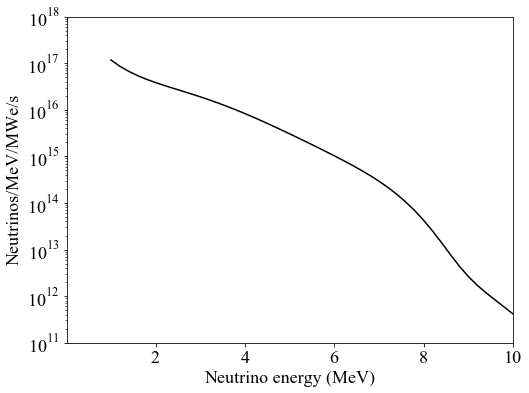

In [54]:

E_thr = np.linspace(0.,10.,200)
E_nu = cs_xe129['E'].values
dE_nu = E_nu[2] - E_nu[1]

reactor = ReactorSpectra.ReactorSpectra()
reactor.reactorPower = 1.e6
reactor.ComputeFullSpectrum( E_nu )
print('Total antineutrinos emitted per second: {}'.format(sum(reactor.fullSpectrum)*dE_nu))
luminosity = np.sum(reactor.fullSpectrum)*dE_nu

detector = Detector.XenonDetector()
detector.distance = 0.01
detector.ComputeSolidAngleFraction()
print('Flux factor at detector: {}'.format(detector.fluxFactor))

print('Plotting reactor neutrino spectrum...')
plt.plot(E_nu,reactor.fullSpectrum,'-k')
plt.axis([0.01,10.,1.e11,1.e18])
plt.yscale('log')
plt.xlabel('Neutrino energy (MeV)')
plt.ylabel('Neutrinos/MeV/MWe/s')
plt.savefig('input_reactor_antineutrino_spectrum.png',dpi=600)

In [55]:
# Spectrum-averaged cross sections:
norm_spectrum = reactor.fullSpectrum/(np.sum(reactor.fullSpectrum)*dE_nu)

print('Energy-averaged cross section for Xe-129: {}'.format( \
                np.sum(norm_spectrum*cs_xe129['CS']*dE_nu)))

print('Energy-averaged cross section for Xe-131: {}'.format( \
                np.sum(norm_spectrum*cs_xe131['CS ']*dE_nu)))



Energy-averaged cross section for Xe-129: 3.0424094669392796e-46
Energy-averaged cross section for Xe-131: 1.8799542898437213e-45


### Computing the fluxes at underground lab sites

We now scale the luminosity by the square of the distance (in cm) to each underground lab, to calculate the flux.

In [56]:
# Use luminosity, now multiply each by its MWe power and then scale by the 1/distance^2

db_reactors['Flux at Homestake'] = np.zeros(len(db_reactors['lat (-90 to 90)']))
db_reactors['Flux at LNGS'] = np.zeros(len(db_reactors['lat (-90 to 90)']))
db_reactors['Flux at SNOLAB'] = np.zeros(len(db_reactors['lat (-90 to 90)']))

for index,row in db_reactors.iterrows():
    db_reactors['Flux at Homestake'].loc[index] = \
        luminosity * row['Gross (MWe)'] / (4 * np.pi * (row['Dist to Homestake']*1.e5)**2 )
    db_reactors['Flux at LNGS'].loc[index] = \
        luminosity * row['Gross (MWe)'] / (4 * np.pi * (row['Dist to LNGS']*1.e5)**2 )
    db_reactors['Flux at SNOLAB'].loc[index] = \
        luminosity * row['Gross (MWe)'] / (4 * np.pi * (row['Dist to SNOLAB']*1.e5)**2 )




In [57]:
print(db_reactors[['Country','Dist to Homestake']].iloc[0:5])

     Country  Dist to Homestake
0        NaN                NaN
1    ARMENIA        8185.837207
2    ARMENIA        8185.837207
3  ARGENTINA        8864.483920
4  ARGENTINA        8570.328643


In [58]:
PRINT_MAJOR_CONTRIBUTORS = True

flux_at_homestake = np.sum( db_reactors['Flux at Homestake'].loc[op_mask] )

flux_at_lngs = np.sum( db_reactors['Flux at LNGS'].loc[op_mask] )

flux_at_snolab = np.sum( db_reactors['Flux at SNOLAB'].loc[op_mask])


if PRINT_MAJOR_CONTRIBUTORS:
    big_contributor_mask = (db_reactors['Flux at Homestake'] > 1.e3)&(op_mask)
    print('Biggest contributors at Homestake:')
    print(db_reactors[['Sitename','Location','Dist to Homestake','Flux at Homestake']].loc[big_contributor_mask])

    big_contributor_mask = (db_reactors['Flux at LNGS'] > 2.e3)&(op_mask)
    print('\n\n\n')
    print('Biggest contributors at LNGS:')
    print(db_reactors[['Country','Location','Dist to LNGS','Flux at LNGS']].loc[big_contributor_mask])

    big_contributor_mask = (db_reactors['Flux at SNOLAB'] > 2.e3)&(op_mask)
    print('\n\n\n')
    print('Biggest contributors at SNOLAB:')
    print(db_reactors[['Country','Location','Dist to SNOLAB','Flux at SNOLAB']].loc[big_contributor_mask])



Biggest contributors at Homestake:
           Sitename           Location  Dist to Homestake  Flux at Homestake
466      MONTICELLO  Wright County, MN         787.222503        1118.994767
480  FORT CALHOUN-1              2, NE         698.657360        1052.656052
488          COOPER         Nemaha, NE         799.239120        1258.415500
563      WOLF CREEK        Hampden, KS         954.899253        1414.272277




Biggest contributors at LNGS:
         Country               Location  Dist to LNGS  Flux at LNGS
51   SWITZERLAND         Olten District    701.721913   2160.333479
52   SWITZERLAND       Zurzach District    711.509779   2527.513277
80       GERMANY              Karlsruhe    853.224359   2023.692735
81       GERMANY               Günzburg    717.357851   2621.033464
83       GERMANY               Günzburg    717.357851   2621.033464
85       GERMANY               Landshut    690.920369   3121.874704
89       GERMANY              Heilbronn    807.314121   2155.698135
15

In [59]:

print('Flux at Homestake: {:2.2F}'.format(flux_at_homestake))
print('Flux at LNGS: {:2.2F}'.format(flux_at_lngs))
print('Flux at SNOLAB: {:2.2F}'.format(flux_at_snolab))


Flux at Homestake: 49224.65
Flux at LNGS: 135419.56
Flux at SNOLAB: 298983.46


### Compute the event rate 

And finally, we can fold the cross section in with the energy spectrum, 
scale by the flux, and the scale by the number of atoms per ton and number of seconds
per year to get the final event rate per ton year in a natural xenon detector. 

In [60]:
#First, normalize the reactor neutrino spectrum to 1 neutrino/MeV
norm_spectrum = reactor.fullSpectrum/(np.sum(reactor.fullSpectrum)*dE_nu)


# Next, scale this with the flux at each site, fold it with the cross section,
# and integrate to get the number of interactions at each site. 
num_at_homestake129 = np.sum(flux_at_homestake*norm_spectrum*cs_xe129['CS']*dE_nu)
num_at_homestake131 = np.sum(flux_at_homestake*norm_spectrum*cs_xe131['CS ']*dE_nu)

num_at_LNGS129 = np.sum(flux_at_lngs*norm_spectrum*cs_xe129['CS']*dE_nu)
num_at_LNGS131 = np.sum(flux_at_lngs*norm_spectrum*cs_xe131['CS ']*dE_nu)

num_at_SNOLAB129 = np.sum(flux_at_snolab*norm_spectrum*cs_xe129['CS']*dE_nu)
num_at_SNOLAB131 = np.sum(flux_at_snolab*norm_spectrum*cs_xe131['CS ']*dE_nu)

# Next, scale this by the number of seconds in a year and the number
# of atoms in a ton of natXe to get an interaction rate.
rate_at_homestake129 = num_at_homestake129*6.02e23*0.264*1.e6/131.*(60.*60.*24.*365)
rate_at_homestake131 = num_at_homestake131*6.02e23*0.212*1.e6/131.*(60.*60.*24.*365)
rate_at_lngs129 = num_at_LNGS129*6.02e23*0.264*1.e6/131.*(60.*60.*24.*365)
rate_at_lngs131 = num_at_LNGS131*6.02e23*0.212*1.e6/131.*(60.*60.*24.*365)
rate_at_snolab129 = num_at_SNOLAB129*6.02e23*0.264*1.e6/131.*(60.*60.*24.*365)
rate_at_snolab131 = num_at_SNOLAB131*6.02e23*0.212*1.e6/131.*(60.*60.*24.*365)

In [61]:
print("Number of interactions at Homestake (Xe129 per ton per year): {:.3e}".format(rate_at_homestake129))
print("Number of interactions at Homestake (Xe131 per ton per year): {:.3e}".format(rate_at_homestake131))
print("Number of interactions at LNGS (Xe129 per ton per year): {:.3e}".format(rate_at_lngs129))
print("Number of interactions at LNGS (Xe131 per ton per year): {:.3e}".format(rate_at_lngs131))
print("Number of interactions at SNOLAB (Xe129 per ton per year): {:.3e}".format(rate_at_snolab129))
print("Number of interactions at SNOLAB (Xe131 per ton per year): {:.3e}".format(rate_at_snolab131))



Number of interactions at Homestake (Xe129 per ton per year): 5.730e-07
Number of interactions at Homestake (Xe131 per ton per year): 2.843e-06
Number of interactions at LNGS (Xe129 per ton per year): 1.576e-06
Number of interactions at LNGS (Xe131 per ton per year): 7.822e-06
Number of interactions at SNOLAB (Xe129 per ton per year): 3.480e-06
Number of interactions at SNOLAB (Xe131 per ton per year): 1.727e-05


## Geo-antineutrinos

Another source of antineutrinos which could create background events via charged-current scattering is geological nuclear reactions. The neutrinos here are released by Th232, U238, or K40 decays in the earth. Below we compute their spectrum, then fold this with the cross section to find an event rate.

In [62]:
import Geoneutrinos
geo = Geoneutrinos.Geoneutrinos()

In [63]:
geo.LoadData('Geo_neutrinos/Th_U_K decay betas.xlsx')

Adding Th234
Adding Pa234
Adding Pb214
Adding Bi214
Adding Bi210
Adding Pb210
Adding Bi212
Adding Tl208
Adding Pb212
Adding Ra228
Adding K40


In [64]:
E_test = np.linspace(0.,5.,1000)
u238specs,u238_spec = geo.U238_spectrum(E_test)
k40specs,k40_spec = geo.K40_spectrum(E_test)
th232specs,th232_spec = geo.Th232_spectrum(E_test)

Neutrinos per decay (U238): 6.0
Neutrinos per decay (Th232): 2.77
Neutrinos per decay (K40): 0.893


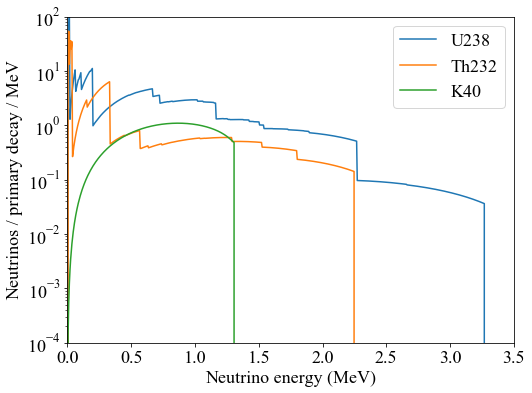

In [65]:
plt.plot(E_test,u238_spec,label='U238')
plt.plot(E_test,th232_spec,label='Th232')
plt.plot(E_test,k40_spec,label='K40')
plt.yscale('log')
print('Neutrinos per decay (U238): {:.3}'.format(np.sum(u238_spec*(E_test[2]-E_test[1]))))
print('Neutrinos per decay (Th232): {:.3}'.format(np.sum(th232_spec*(E_test[2]-E_test[1]))))
print('Neutrinos per decay (K40): {:.3}'.format(np.sum(k40_spec*(E_test[2]-E_test[1]))))
plt.axis([0.,3.5,1.e-4,1.e2])
plt.xlabel('Neutrino energy (MeV)')
plt.ylabel('Neutrinos / primary decay / MeV')
plt.legend(loc='upper right')


This is fine, but we really need a differential flux. So, we need to weight each of these by the amount of each isotope which is in the earth, then calculate an approximate total flux. The latter would require some sort of earth model, but it seems like the geoneutrino flux doesn't change all that much in different locations. So, we'll just use the one computed for KAMLAND.

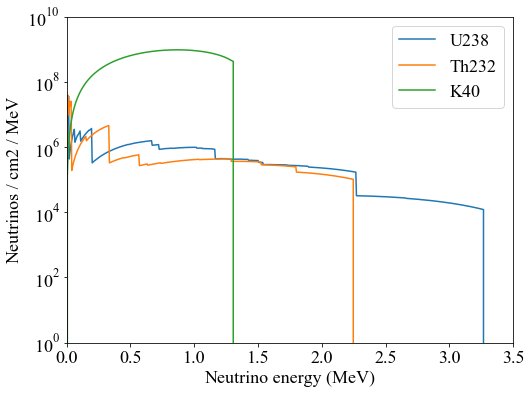

In [66]:
# Weighting each of these according to some flux numbers:
wu238_spec = u238_spec/np.sum(u238_spec*(E_test[2]-E_test[1])) * 2.e6
wth232_spec = th232_spec/np.sum(th232_spec*(E_test[2]-E_test[1])) * 2.e6
wk40_spec = k40_spec/np.sum(k40_spec*((E_test[2]-E_test[1]))) * 7.8e8

# Note: the 7.8e8 number comes from Bezrukov, 
# but is at least an order of magnitude higher than other sources.
# Maybe not trustworthy.


plt.plot(E_test,wu238_spec,label='U238')
plt.plot(E_test,wth232_spec,label='Th232')
plt.plot(E_test,wk40_spec,label='K40')
plt.yscale('log')
plt.axis([0.,3.5,1.,1.e10])
plt.xlabel('Neutrino energy (MeV)')
plt.ylabel('Neutrinos / cm2 / MeV')
plt.legend(loc='upper right')





Now that I've checked that my results are roughly consistent with other work, and I can weight the distributions appropriately, I'll fold in with the Pirinen cross sections.



In [67]:

u238specs,u238_spec = geo.U238_spectrum(cs_xe129['E'])
k40specs,k40_spec = geo.K40_spectrum(cs_xe129['E'])
th232specs,th232_spec = geo.Th232_spectrum(cs_xe129['E'])

wu238_spec = u238_spec/np.sum(u238_spec*(dE_nu)) * 2.e6
wth232_spec = th232_spec/np.sum(th232_spec*(dE_nu)) * 2.e6
wk40_spec = k40_spec/np.sum(k40_spec*((dE_nu))) * 7.8e8

total_spec = wu238_spec + wth232_spec + wk40_spec




# This cross section is given in neutrinos/MeV/cm2/s
print('Spectrum-averaged cross-sections:')
print('      \t{:<9}\t{:<9}'.format('Xe129','Xe131'))
print('U238:\t{:9.2e}\t{:9.3e}'.format(\
                    np.sum(wu238_spec/np.sum(wu238_spec*dE_nu)*cs_xe129['CS']),\
                    np.sum(wu238_spec/np.sum(wu238_spec*dE_nu)*cs_xe131['CS '])))
print('Th232:\t{:9.3e}\t{:9.3e}'.format(\
                    np.sum(wth232_spec/np.sum(wth232_spec*dE_nu)*cs_xe129['CS']),\
                    np.sum(wth232_spec/np.sum(wth232_spec*dE_nu)*cs_xe131['CS '])))
print('K40:\t{:9.3e}\t{:9.3e}'.format(\
                    np.sum(wk40_spec/np.sum(wk40_spec*dE_nu)*cs_xe129['CS']),\
                    np.sum(wk40_spec/np.sum(wk40_spec*dE_nu)*cs_xe131['CS '])))


print('\n\n')
print('Total event rate per ton*year:')
print('Xe129: {:7.3e}'.format(np.sum(total_spec *cs_xe129['CS']*dE_nu) *\
             6.02e23*1.e6/131. * (60.*60.*24.*365.)))
print('Xe131: {:7.3e}'.format(np.sum(total_spec *cs_xe131['CS ']*dE_nu) *\
             6.02e23*1.e6/131. * (60.*60.*24.*365.)))


Spectrum-averaged cross-sections:
      	Xe129    	Xe131    
U238:	 2.85e-48	3.180e-46
Th232:	4.285e-49	7.710e-47
K40:	0.000e+00	0.000e+00



Total event rate per ton*year:
Xe129: 1.902e-07
Xe131: 2.290e-05


So, we can see that the event rate for geoneutrinos is also negligible. (DARWIN has an exposure of ~10^2 ton\*year.) 

## Conclusions
Antineutrino charge-current scattering from both reactors and geoneutrino sources are completely negligible for this search. Rates are less than 10^-2 events in the expected exposures for DARWIN. For nEXO, the threshold for neutrino capture on Xe-136 is too high, so it will not be a background here, either.

# Charged-current scattering of solar neutrinos.

## Induced radioactivity from B8 neutrinos (B+ and B- emitters)

B8 neutrino capture on different isotopes of xenon can produce radioactive isotopes of Cs that may create backgrounds for a Xe-124 search. There are two types of backgrounds here:
1. B+ emitters - Cs-128, Cs-129, and Cs-130 may decay via B+ emission, creating a direct background for our search. In particular, Cs-128 and Cs-130 have high-energy endpoints, directly sweeping out our region of interest.
2. B- emitters - Cs-132 and Cs-136 are B- emitters with high endpoint energies, and may decay via the emission of gammas that could mask our signal. Therefore, we calculate their rates and will simulate their spectra accordingly. 



In [68]:
# These data are copied directly from Table V in PRC 99, 014320
pirinen_b8_cs = { 'Xe128':1.22e-42,\
                'Xe129':21.1e-42,\
                'Xe130':2.15e-42,\
                'Xe131':30.9e-42,\
                'Xe132':3.63e-42,\
                'Xe134':5.97e-42,\
                'Xe136':12.1e-42 }

In [69]:
# Capture rate per ton (of each isotope) per year
capture_rates = dict()
print('B8 neutrino capture rates for each isotope per year\n(per ton of that isotope):')
for key, value in pirinen_b8_cs.items():
    rate = value * 5.56e6 * 6.02e23*1.e6/131. * (24.*60.*60.*365.)
    capture_rates.update( {key: rate})
    print('{:<7}\t{:>7.3}'.format(key,rate))

B8 neutrino capture rates for each isotope per year
(per ton of that isotope):
Xe128  	  0.983
Xe129  	   17.0
Xe130  	   1.73
Xe131  	   24.9
Xe132  	   2.92
Xe134  	   4.81
Xe136  	   9.75


We can safely ignore Cs131 and Cs134, since they do not decay with enough energy to be a background in our search.

## Induced radioactivity in Xe-136 (and Xe-131) from CNO, pp, and Be7 neutrinos

Xe-136 and Xe-131 both have very low thresholds for neutrino capture (86 keV and 352 keV, respectively). This means they are sensitive to neutrino capture from lower-energy (but much more abundant) solar neutrinos from the CNO cycle, the Be7 reaction, and the pp-reaction.

For our purposes here, Xe-131 is not an issue because the daughter (Cs-131) decays via an electron capture reaction with a Q-value too small to create backgrounds in our search. We perform all of the relevant calculations below for both Xe-131 and X-136, but only really look at Xe-136 in our final background analysis.

In [70]:
# First, load the cross sections obtained from Pekka Pirinen, then plot them.
cs_xe131 = pd.read_csv('pirinen_cross_sections/131Xe_Cs_neutrino.dat',delimiter='\t',skiprows=2,index_col=False)
cs_xe136 = pd.read_csv('pirinen_cross_sections/136Xe_Cs_neutrino.dat',delimiter='\t',skiprows=2,index_col=False)



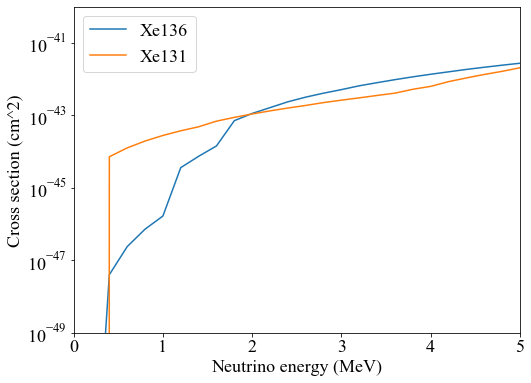

In [93]:
plt.plot(cs_xe136['E'],cs_xe136['CS'],label='Xe136')
plt.plot(cs_xe131['E'],cs_xe131['CS'],label='Xe131')

plt.ylabel('Cross section (cm^2)')
plt.xlabel('Neutrino energy (MeV)')
plt.legend()

plt.ylim(1.e-49,1.e-40)
plt.xlim(0.,5.)
plt.yscale('log')

In [72]:
# Need to load in the spectra for solar neutrinos. These spectra were digitized
# from the plot in the Borexino nature paper on PP neutrinos.

n13solar = pd.read_csv('CNO_neutrinos/N13_spectrum.txt',header=None)
o15solar = pd.read_csv('CNO_neutrinos/O15_spectrum.txt',header=None)
be7solar = pd.read_csv('CNO_neutrinos/Be7_flux.txt',header=None)
ppsolar = pd.read_csv('CNO_neutrinos/PP_spectrum.txt',header=None)
b8solar = pd.read_csv('CNO_neutrinos/B8_spectrum/data.txt',delimiter=' ',header=None)

In [73]:
# To get analytic functions for each neutrino spectrum, we fit the digitized
# data to different empirical functions.

def fitfunc(x,A,mu,sig,exp):
    return A*np.exp( -np.abs(x-mu)**exp/(2*sig**exp) )

def twosidedgengauss(x,A,mu,sig1,sig2,exp):
    mask = x < mu
    output = np.zeros(len(x))
    output[mask] = A*np.exp(-np.abs(x[mask]-mu)**exp/(2*sig1**exp))
    output[np.invert(mask)] = A*np.exp(-np.abs(x[np.invert(mask)]-mu)**exp/(2*sig2**exp))
    return output


Fit to O15:
[ 8.03149038e+07 -4.34267242e+08  1.07448119e+09 -1.90088142e+09
  1.61699402e+09 -4.75885973e+07  5.71485221e+06]
Fit to N13:
[-1.71717973e+10  5.39759822e+10 -6.22801751e+10  2.98119021e+10
 -5.04825616e+09  1.31682926e+09 -6.87366147e+07]
Fit to PP:
[-5.19786304e+15  6.87214494e+15 -3.62868136e+15  9.59811389e+14
 -1.33246285e+14  1.03026497e+13 -2.95903882e+11]
Fit to B8:
O15 endpoint: 1.69e+00
N13 endpoint: 1.15e+00
PP endpoint: 4.22e-01
B8 endpoint: 1.60e+01


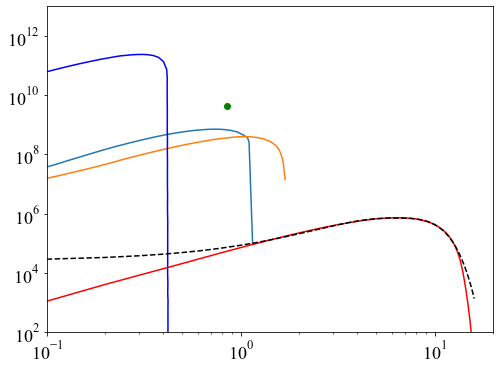

In [74]:
plt.plot(n13solar[0],n13solar[1],label='N13')
plt.plot(o15solar[0],o15solar[1],label='O15')
plt.plot(be7solar[0],be7solar[1],'og',label='Be7')
plt.plot(ppsolar[0],ppsolar[1],'-b')
plt.plot(b8solar[0],b8solar[1]*5.56e6,'-r',label='B8')
plt.axis([0.1,20.,1.e2,1.e13])
plt.yscale('log')
plt.xscale('log')

# These spectra are analyzed by fitting 6th order polynomials, truncated at the endpoints.
print('Fit to O15:')
p = np.polyfit(o15solar[0],o15solar[1],6)
print(p)
print('Fit to N13:')
p = np.polyfit(n13solar[0],n13solar[1],6)
print(p)
print('Fit to PP:')
p = np.polyfit(ppsolar[0],ppsolar[1],6)
print(p)
print('Fit to B8:')
import scipy.optimize as opt
p,cov = opt.curve_fit(twosidedgengauss,b8solar[0],b8solar[1],p0=(0.132,6.3,2.8,3.6,2.3))

#plt.clf()
plt.plot(b8solar[0],b8solar[1],'.r',label='B8')
#plt.plot(b8solar[0],twosidedgengauss(b8solar[0],0.132,6.3,2.8,3.6,2.3),'--k')
plt.plot(b8solar[0],5.56e6*twosidedgengauss(b8solar[0],p[0],p[1],p[2],p[3],p[4]),'--k')
                                     
                                     
                                     
print('O15 endpoint: {:.2e}'.format(o15solar[0].iloc[-1]))
print('N13 endpoint: {:.2e}'.format(n13solar[0].iloc[-1]))
print('PP endpoint: {:.2e}'.format(ppsolar[0].iloc[-1]))
print('B8 endpoint: {:.2e}'.format(b8solar[0].iloc[-1]))


In [75]:
def O15spectrum( E_nu ):
    spectrum = np.zeros(len(E_nu))
    mask = E_nu < 1.69e+00 # MeV
    spectrum[mask] =  8.03149038e+07*E_nu[mask]**6 - 4.34267242e+08*E_nu[mask]**5  + \
           1.07448119e+09*E_nu[mask]**4 - 1.90088142e+09*E_nu[mask]**3 + \
           1.61699402e+09*E_nu[mask]**2 - 4.75885973e+07*E_nu[mask]  + 5.71485221e+06
    return spectrum
    
def N13spectrum( E_nu ):
    spectrum = np.zeros(len(E_nu))
    mask = E_nu < 1.15e+00 # MeV
    spectrum[mask] = -1.71717973e+10*E_nu[mask]**6 + 5.39759822e+10*E_nu[mask]**5 - \
                     6.22801751e+10*E_nu[mask]**4 + 2.98119021e+10*E_nu[mask]**3 - \
                     5.04825616e+09*E_nu[mask]**2 + 1.31682926e+09*E_nu[mask] - 6.87366147e+07
    return spectrum

def PPspectrum( E_nu ):
    spectrum = np.zeros(len(E_nu))
    mask = E_nu < 4.22e-01 # MeV
    spectrum[mask] = -5.19786304e+15*E_nu[mask]**6 + 6.87214494e+15*E_nu[mask]**5 - \
                      3.62868136e+15*E_nu[mask]**4 + 9.59811389e+14*E_nu[mask]**3 - \
                      1.33246285e+14*E_nu[mask]**2 + 1.03026497e+13*E_nu[mask] - 2.95903882e+11
    return spectrum


def B8spectrum( E_nu ):
    spectrum = np.zeros(len(E_nu))
    mask = E_nu < 1.60e+01 # MeV
    spectrum[mask] = -7.38146863e-01*E_nu[mask]**6 + 1.66199822e+01*E_nu[mask]**5 + \
                      2.88622505e+02*E_nu[mask]**4 - 9.75589005e+03*E_nu[mask]**3 + \
                    6.04575230e+04**E_nu[mask]**2 + 3.36513246e+04*E_nu[mask] - 9.20328867e+03
    return spectrum * 5.56e6


Let's then fold this in with the cross sections from Pirinen.

Total rate of Cs136 production from CNO neutrinos:
6.613e-02 per ton*year
Total rate of Cs131 production from CNO neutrinos:
1.110e+01 per ton*year


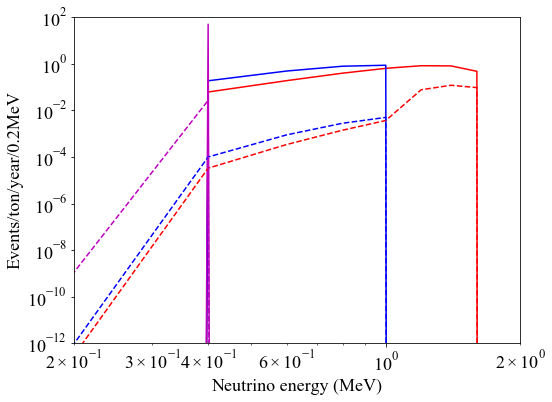

In [76]:
o15diffrate = cs_xe136['CS']*O15spectrum(cs_xe136['E']) * 6.02e23*1.e6/136. * (24.*24.*60.*365.)
n13diffrate = cs_xe136['CS']*N13spectrum(cs_xe136['E']) * 6.02e23*1.e6/136. * (24.*24.*60.*365.)
b8diffrate = cs_xe136['CS']*5.56e6*twosidedgengauss(cs_xe131['E'],p[0],p[1],p[2],p[3],p[4]) * 6.02e23*1.e6/136. * (24.*24.*60.*365.)
ppdiffrate = cs_xe136['CS']*PPspectrum(cs_xe136['E']) * 6.02e23*1.e6/136. * (24.*24.*60.*365.)


o15diffrate131 = cs_xe131['CS']*O15spectrum(cs_xe136['E']) * 6.02e23*1.e6/131. * (24.*24.*60.*365.)
n13diffrate131 = cs_xe131['CS']*N13spectrum(cs_xe136['E']) * 6.02e23*1.e6/131. * (24.*24.*60.*365.)
b8diffrate131 = cs_xe131['CS']*5.56e6*twosidedgengauss(cs_xe131['E'],p[0],p[1],p[2],p[3],p[4]) * 6.02e23*1.e6/131. * (24.*24.*60.*365.)
ppdiffrate131 = cs_xe131['CS']*PPspectrum(cs_xe131['E']) * 6.02e23*1.e6/131. * (24.*24.*60.*365.)

plt.plot(cs_xe131['E'],o15diffrate131,'-r')
plt.plot(cs_xe131['E'],n13diffrate131,'-b')
#plt.plot(cs_xe131['E'],b8diffrate131,'-g')
plt.plot(cs_xe131['E'],ppdiffrate131,'-m')
plt.plot(cs_xe136['E'],o15diffrate,'--r')
plt.plot(cs_xe136['E'],n13diffrate,'--b')
#plt.plot(cs_xe136['E'],b8diffrate,'--g')
plt.plot(cs_xe136['E'],ppdiffrate,'--m')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Events/ton/year/0.2MeV')
plt.xlabel('Neutrino energy (MeV)')
plt.axis([0.2,2.,1.e-12,1.e2])

print('Total rate of Cs136 production from CNO neutrinos:')
print('{:.3e} per ton*year'.format( (np.sum(o15diffrate) + np.sum(n13diffrate) + np.sum(ppdiffrate))*dE_nu ))

print('Total rate of Cs131 production from CNO neutrinos:')
print('{:.3e} per ton*year'.format( (np.sum(o15diffrate131) + np.sum(n13diffrate131) + np.sum(ppdiffrate131))*dE_nu ))





In [77]:
print(be7solar.iloc[0])
below = cs_xe136['CS'].loc[ cs_xe136['E']<8.535454e-01 ].iloc[-1]
above = cs_xe136['CS'].loc[cs_xe136['E']>8.535454e-01 ].iloc[0]
be7_xe136_cs = (below+above)/0.2*(0.853-0.8) + below

below = cs_xe131['CS'].loc[ cs_xe131['E']<8.535454e-01 ].iloc[-1]
above = cs_xe131['CS'].loc[cs_xe131['E']>8.535454e-01 ].iloc[0]
be7_xe131_cs = (below+above)/0.2*(0.853-0.8) + below


print('Be7 rate on Xe136: {:.3e} evts/ton/yr'.format( be7_xe136_cs * be7solar[1].iloc[0] * 6.02e23*1.e6/136. * (60.*60.*24.*365.)))
print('Be7 rate on Xe131: {:.3e} evts/ton/yr'.format( be7_xe131_cs * be7solar[1].iloc[0] * 6.02e23*1.e6/136. * (60.*60.*24.*365.)))



0    8.535454e-01
1    4.202455e+09
Name: 0, dtype: float64
Be7 rate on Xe136: 7.929e-02 evts/ton/yr
Be7 rate on Xe131: 1.877e+01 evts/ton/yr


In [78]:
print('Total production of Cs-136 from low energy solar neutrinos:')
print('{:.2e} evts/ton(Xe136)/year'.format(be7_xe136_cs * be7solar[1].iloc[0] * 6.02e23*1.e6/136. * (60.*60.*24.*365.) + \
                     (np.sum(o15diffrate) + np.sum(n13diffrate) + np.sum(ppdiffrate))*dE_nu))

Total production of Cs-136 from low energy solar neutrinos:
1.45e-01 evts/ton(Xe136)/year


The total production of Cs-136 from low-energy solar neutrinos is negligible compared to the production from B8 neutrinos. This is due to the much higher cross section for charged-current scattering at higher energies. Therefore, we'll ignore this.

## Prompt scattering into excited states

Here we quantify the rate of the prompt signal from B8 neutrinos scattering off of Xe isotopes. These may create backgrounds due to the emitted electron + gamma rays from the decay of the excited Cs daughter nucleus. However, they can only create backgrounds if the total energy is less than 2.8 MeV - we assume that events with higher total energies will be rejected by our analysis. This means that, rather than using the total cross section for B8 neutrino scatter, we need only use the partial cross sections for scattering into excited states below 2.8 MeV. Fortunately, Pirinen shows these graphically for four isotopes, reproduced below:

<img src="CNO_neutrinos/partial_cross_sections_pirinen.png">

In [79]:
# Partial cross sections for energies below ~2.8MeV, digitized from the plot above:
xe128_partial = pd.DataFrame( {'Energy': [1.99009,2.35749,3.11506],\
                              'CS': [4.77272,1.11570,2.024793]} )
xe134_partial = pd.DataFrame({'Energy': [1.67741,1.741935,2.838709],\
                            'CS': [14.5449,8.00446,11.0931223]})
xe129_partial = pd.DataFrame({'Energy': [0.776119,1.68801,2.13047,2.2758786],\
                            'CS': [0.298507,1.641791, 0.22388,2.76119]})
xe131_partial = pd.DataFrame({'Energy': [1.09677,1.74193,2,2.32258,2.258064,2.5161290,2.838709,2.967741],\
                            'CS': [4.64516,0.1290,0.25806,1.87096,1.354838,0.0645161,0.1290322,2.06451612]})


In [80]:
print('Total cross sections for low-energy states:')
print('Xe128: {:.3e}'.format(np.sum(xe128_partial['CS'])*1.e-43))
print('Xe131: {:.3e}'.format(np.sum(xe131_partial['CS'])*1.e-43))
print('Xe134: {:.3e}'.format(np.sum(xe134_partial['CS'])*1.e-43))
print('Xe129: {:.3e}'.format(np.sum(xe129_partial['CS'])*1.e-43))

Total cross sections for low-energy states:
Xe128: 7.913e-43
Xe131: 1.052e-42
Xe134: 3.364e-42
Xe129: 4.925e-43


Isotope 	Fraction	Rate    	ROI frac	ROI rate
Xe-128  	2.29e-01	1.45e-01	7.15e-03	4.54e-03
Xe-129  	1.32e-01	1.11e-01	5.67e-03	4.79e-03
Xe-131  	8.40e-02	2.27e-01	4.35e-03	1.18e-02
Xe-134  	1.34e-01	5.30e-02	5.73e-03	2.26e-03

Rates are calculated per ton*year of each isotope.


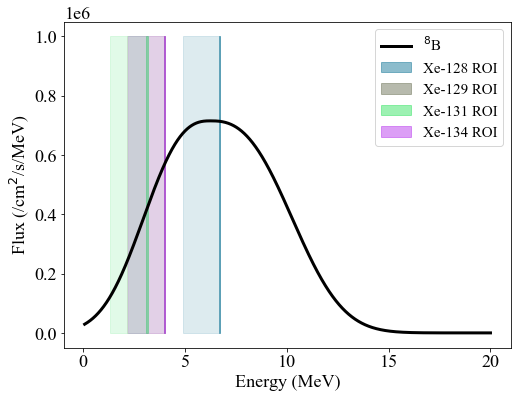

In [81]:
xfit = np.linspace(0.1,20.,10000)
yfit = twosidedgengauss(xfit,p[0],p[1],p[2],p[3],p[4])
yfit = 5.56e6 * yfit / (np.sum(yfit)*(xfit[2]-xfit[1]))

plt.plot(xfit,yfit,'-k',label='$^8$B',linewidth=3)
plt.xlabel('Energy (MeV)')
plt.ylabel('Flux (/cm$^2$/s/MeV)')
plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(0,0))


thresholds = [3.929, 1.197, 0.355, 1.233]
isotopes = ['Xe-128','Xe-129','Xe-131','Xe-134']
avg_cross_sec =  [7.913e-43, 1.052e-42, 3.364e-42, 4.925e-43]
nat_abund = [0.019, 0.26401, 0.21232, 0.104356]

fractions = np.zeros(len(thresholds))
roi_fractions = np.zeros(len(thresholds))
rate_per_ton_year = np.zeros(len(thresholds))
rate_per_ton_year_roi = np.zeros(len(thresholds))


print('{:<8}\t{:<8}\t{:<8}\t{:<8}\t{:<8}'.format('Isotope','Fraction','Rate','ROI frac','ROI rate'))
for i in range(0,len(thresholds)):
    col = (np.random.uniform(),np.random.uniform(),np.random.uniform())
    
    mask = (xfit>thresholds[i]+1.)&(xfit<thresholds[i]+2.8)
    fractions[i] = np.sum(yfit[mask])/np.sum(yfit)
    mask = (xfit>thresholds[i]+(2.8-0.01*2.8))&(xfit<thresholds[i]+(2.8+0.01*2.8))
    roi_fractions[i] = np.sum(yfit[mask])/np.sum(yfit)
    rate_per_ton_year[i] = 5.56e6*avg_cross_sec[i]*fractions[i]*6e23/131.*1.e6*(60*60*24*365)#*nat_abund[i]
    rate_per_ton_year_roi[i] = 5.56e6*avg_cross_sec[i]*roi_fractions[i]*6e23/131.*1.e6*(60*60*24*365)#*nat_abund[i]
    x1 = np.ones(10)*thresholds[i]+(2.8-0.01*2.8) #1.
    x2p8 = np.ones(10)*thresholds[i]+(2.8+0.01*2.8) #2.8
    y = np.linspace(0.,1.e6,10)
    plt.fill_betweenx(y,x1,x2p8,color=col,alpha=0.5,label='{} ROI'.format(isotopes[i]))
    x1 = np.ones(10)*thresholds[i]+1.
    x2p8 = np.ones(10)*thresholds[i]+2.8
    y = np.linspace(0.,1.e6,10)
    plt.fill_betweenx(y,x1,x2p8,alpha=0.15,color=col)
    #plt.axis([0.,16.,0.,5.e6])
    print('{:<8}\t{:8.2e}\t{:8.2e}\t{:8.2e}\t{:8.2e}'.format(isotopes[i],fractions[i],rate_per_ton_year[i],roi_fractions[i],rate_per_ton_year_roi[i]))
    #print('{:.5F}'.format(roi_fractions[i]))
plt.legend(fontsize=15) 
plt.savefig('B8_spectrum_with_rois_4.png',dpi=300,bbox_inches='tight')

print('\nRates are calculated per ton*year of each isotope.')

This is undoubtedly an overestimate - the partial cross sections given for each excited state are averaged over the entire B8 neutrino spectrum. At lower energies, between 1 - 2.8 MeV above threshold, we expect these cross sections to be about an order of magnitude smaller (near ~1e-43). This is evident in the energy-dependent cross sections shown above for Xe-136 and Xe-131. 

Even given this overestimate, we find that we get ~10^-1 events per ton of each isotope per year in a broad spectrum. This would produce O(1) event in the DARWIN exposure after accounting for the natural abundances of the isotopes (O(0.1) in the ROI for the 0nu searches), and would need a very specific event topolgy to mimic our expected signal. As such, we will consider this negligible.

Note that the reason this is significantly smaller than the induced radioactivity is that the latter is induced by the ENTIRE B8 spectrum. The cross section goes up with the square of the neutrino energy, so the rates above are dominated by the higher energy neutrinos, which will create too much prompt energy to be counted here.

## Conclusions

The only backgrounds we need worry about from neutrino charged-current interactions are the radioactive Cs daughter nuclei, Cs-128, Cs-129, Cs-130, Cs-132, and Cs-136. The production rate per ton year for each isotope is:

- Xe128: 0.98 atoms/ton/year
- Xe129: 17.0 atoms/ton/year
- Xe130: 1.73 atoms/ton/year
- Xe132: 2.92 atoms/ton/year
- Xe136: 9.75 atoms/ton/year

# External gamma scattering

Residual radioactivity in the detector components will produce gamma rays that may compton scatter and thereby mimic our multiple-scatter signal of interest. To address this background, we will perform a full Geant4 simulation in which U238 and Th232 are allowed to decay in a thin copper shell around the active Xenon volume, and we will measure how many of these events pass our cuts. 

However, we do need to estimate a radioactivity in order to understand how to scale these events. 

The NIM paper from EXO-200 suggests that copper has O(10e-12) g/g Th and U contamination.

In [82]:
th232_halflife = 1.4e10 * (60.*60.*24.*365.) # seconds
u238_halflife = 4.468e9 * (60.*60.*24.*365.) # seconds

# How many decays per cc of coppter material, in a 10 year exposure?
cu_density = 8.96 # g/cm3
th_density = 10.e-12 * cu_density
u_density = 10.e-12 * cu_density

th_atoms_per_cc = 6.02e23/232. * th_density
u_atoms_per_cc = 6.02e23/238. * u_density

th232_activity_per_cc = th_atoms_per_cc/(th232_halflife/np.log(2))
u238_activity_per_cc = u_atoms_per_cc/(u238_halflife/np.log(2))

print('Th232 activity (Bq/cc): {:.2e}'.format(th232_activity_per_cc))
print('U238 activity (Bq/cc): {:.2e}'.format(u238_activity_per_cc))

print('\nOver 10 years, this corresponds to:')
print('Th232: {:.2e} decays/cc'.format(th232_activity_per_cc*10.*60.*60.*24.*365.))
print('U238:  {:.2e} decays/cc'.format(u238_activity_per_cc*10.*60.*60.*24.*365.))

Th232 activity (Bq/cc): 3.65e-07
U238 activity (Bq/cc): 1.11e-06

Over 10 years, this corresponds to:
Th232: 1.15e+02 decays/cc
U238:  3.52e+02 decays/cc


So, we'll need to scale our simulations to provide this many decays, times the total volume of the copper we assume. So far, the vessel is 1cm thick. Is this a good assumption?

# Neutron-induced backgrounds


There are several ways in which neutrons could create backgrounds in our search:
1. **Prompt neutron capture products** - The gamma rays resulting from neutron capture may mimic our multiple-scatter signal of interest. However, the total energy released is expected to be much higher than our signal region, so we'll assume that these are negligible.
2. **Radionuclides produced by thermal neutron capture** - We may get backgrounds from radiogenic Xe isotopes created by thermal neutron capture. The only such product of any interest is Xe-137, which B-decays with a Q-value well above the ROI. However, this has only two decay modes, either a naked beta (no gammas emitted) or the emission of a single gamma ray at ~450 keV. The former is highly unlikely to create a background, but the latter may fall ito our ROI if the beta undergoes bremmstrahlung and produces a second gamma of ~500 keV. We can simulate 10^6 of these and see how many pass our cuts.
3. **High-energy neutron reactions** - Muogenic neutrons, which can have >10MeV energies, may interact via other reactions, e.g. (n,p), (n,a), or (n,2n). 




## High-energy neutron reactions

For this one, we find that it's a bit complicated. High energy neutrons can penetrate shielding materials typically used in these experiments. XENON1T, for instance, has published simulations showing that 4m of water shielding only reduces the high energy muon flux by a factor of ~10^-2. So if we see appreciable rates here, this may be a problem.

### Xe-124(n,2n)Xe-123

For the (n,2n) reaction, the danger is Xe-124(n,2n)Xe-123, which then decays via B+ emission with a Q-value of 2.6 MeV. This is a direct background to our 2nuB+EC signal. So, let's estimate a production rate at Gran Sasso (the shallowest lab under consideration).

In [83]:
muogenic_neutron_flux = 1.e-9 #n/cm2/s, from XENON1T water shield paper
cross_section = 1.e-24 # cm2, from ENDF at ~15 - 20 MeV

production_rate = cross_section*muogenic_neutron_flux*6.02e23*1.e3/124.*(60.*60.*24.*365)

print('Xe-123 production rate from muogenic neutrons:')
print('\t{:.2e} atoms/kg(Xe124)/yr'.format(production_rate))

Xe-123 production rate from muogenic neutrons:
	1.53e-01 atoms/kg(Xe124)/yr


If the half life for 2nuB+EC is ~10^24 years, this is only a factor of 10 less than the expected rate for our signal. However, the paper on the XENON1T water tank shows that the water shielding reduces the muogenic neutron flux by a factor of 10^-2. Therefore this would be a rate of 10^-3 times our signal rate. It is therefore negligible. 


This being said, the cross section is only evaluated up to 20 MeV, and muogenic neutrons can be produced up to ~GeV energies. There may be an enhancement in the cross section at higher energies, and these neutrons may also be more penetrating. These issues should be studied in more detail in a real experiment.

Gran Sasso is a conservative assumption: the muon-induced neutron flux at Homestake and Sudbury are expected to be approximately 1 and 2 orders of magnitude lower, respectively. This background is therefore assumed to be negligible in both of these labs.



### (n,a), (n,p), etc.


These reactions all have cross sections of order 10^-2 barn. Following the calculation above, the production rate is negligible, particularly if we assume the water shielding has any effect whatsoever. As before, this is not well-measured at higher energies, but for our purposes here we can neglect this entirely. 

# Rn-222 daughters

Rn-222 may dissolve into the active LXe volume and create backgrounds via beta decays that emit gamma rays. However, looking through the decay chain, there are only two beta decays with enough energy to create backgrounds in this analysis. The first, Bi-214, is accompanied by the Po-214 decay about 100us later. We therefore assume it can be rejected via a coincidence analysis. The second, Bi-210, has a Q-value of 1.2MeV (so just at the low energy end of our region of interest), but decays with no accompanying gamma. Therefore, we assume it will almost always be a single-scatter signal, and will therefore not pass our cuts. 

# Conclusions

The work above narrows down the number of simulations we need to run to evaluate our backgrounds. We need to simulate:

1. **External gamma ray backgrounds**
2. **Xe-137 from neutron capture on Xe-136**
3. **Cs-128 from neutrino capture on Xe-128**
4. **Cs-129 from neutrino capture on Xe-129**
5. **Cs-130 from neutrino capture on Xe-130**
6. **Cs-132 from neutrino capture on Xe-132**
7. **Cs-134 from neutrino capture on Xe-134**


The analysis above also provides weighting factors for each of these potential backgrounds, so we can scale them appropriately to reach a final background rate.

In [84]:
copper_mass = (757.*120.+46000.*2)*8/1000.

print( "{:8.5} kg of copper, 121cm radius, 120cm tall".format(copper_mass))
# 1.5 tons of copper for a nEXO-like detector.

# Assume copper is ~10ppt U-238 and 10ppt Th-232
# Copper is about 60AMU, so we have about 60g per mole.
copper_moles = copper_mass/0.060
print('{:4.4} moles of copper'.format(copper_moles))

Uatoms = copper_moles*1e-11 * 6.02e23
Thatoms = copper_moles*1e-11 * 6.02e23

print('{:4.4} atoms of U or Th'.format(Uatoms))

# Activity in decays per second should be:
# probabilith density of an atom decaying is P = A*2^(-t/t1/2)
#probability that an atom decays in one second is P = A*exp( - t / ())

thalf = 10.**10
decays_per_year = Uatoms/thalf
print('{:4.4} decays per year'.format(decays_per_year))

  1462.7 kg of copper, 121cm radius, 120cm tall
2.438e+04 moles of copper
1.468e+17 atoms of U or Th
1.468e+07 decays per year


In [86]:
10**np.log(2)

4.933409667914596

In [90]:
#Threshold for n,2n scattering on Xe-124
m_n = 939.5654133 # MeV
m_p = 938.2720813 # MeV
m_xe124 = 123.905893 # amu
m_xe123 = 122.908482 # amu
mev_per_amu = 931.49410242

print('Threshold = {:4.4}'.format((m_xe123*mev_per_amu + 2 * m_n) - (m_xe124*mev_per_amu + m_n)) )

Threshold = 10.48
